In [18]:
# ============================================================
# Imports
# ============================================================
import uproot
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from torch.utils.data import TensorDataset, DataLoader


In [19]:

# ============================================================
# Device
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [20]:

# ============================================================
# Load ROOT files
# ============================================================
files = {
    "prompt": uproot.open("Prompt_DstarToD0Pi.root"),
    "nonprompt": uproot.open("Nonprompt_DstarToD0Pi.root"),
    "background": uproot.open("Bkg_DstarToD0Pi.root"),
}

trees = {k: v["treeMLDstar"] for k, v in files.items()}

# ============================================================
# Branches
# ============================================================
branches_all = [
    "fPtD0",
    "fCpaD0","fCpaXYD0","fDecayLengthXYD0",
    "fImpactParameterProductD0","fImpParamSoftPi",
    "fMaxNormalisedDeltaIPD0",
    "fNSigTpcPi0","fNSigTpcKa0","fNSigTofPi0","fNSigTofKa0",
    "fNSigTpcPi1","fNSigTpcKa1","fNSigTofPi1","fNSigTofKa1"
]

feature_branches = branches_all[1:]  # drop pT


In [21]:

# ============================================================
# Load arrays
# ============================================================
arrays = {
    k: trees[k].arrays(branches_all, library="np")
    for k in trees
}

# ============================================================
# pT selection
# ============================================================
pt_min, pt_max = 7.0, 10.0

for k in arrays:
    mask = (arrays[k]["fPtD0"] > pt_min) & (arrays[k]["fPtD0"] < pt_max)
    for b in feature_branches:
        arrays[k][b] = arrays[k][b][mask]


In [22]:

# ============================================================
# Feature matrices
# ============================================================
def build_features(arr):
    return np.column_stack([arr[b] for b in feature_branches])

X_prompt     = build_features(arrays["prompt"])
X_nonprompt  = build_features(arrays["nonprompt"])
X_background = build_features(arrays["background"])

# ============================================================
# Labels
# ============================================================
y_prompt     = np.zeros(len(X_prompt))
y_nonprompt  = np.ones(len(X_nonprompt))
y_background = 2 * np.ones(len(X_background))

# ============================================================
# Merge datasets
# ============================================================
X_all = np.vstack((X_prompt, X_nonprompt, X_background))
y_all = np.concatenate((y_prompt, y_nonprompt, y_background))


In [23]:

# ============================================================
# NaN / Inf handling
# ============================================================
X_all = np.nan_to_num(X_all, nan=0.0)

# ============================================================
# Train-test split
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.30, shuffle=True, random_state=42
)

# ============================================================
# Feature scaling
# ============================================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# ============================================================
# Torch tensors
# ============================================================
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)


In [24]:

# ============================================================
# DataLoaders
# ============================================================
batch_size = 4096

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=batch_size,
    shuffle=True
)

# ============================================================
# Model
# ============================================================
class D0Classifier(nn.Module):
    def __init__(self, n_features=14):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )

    def forward(self, x):
        return self.net(x)

model = D0Classifier().to(device)

# ============================================================
# Physics-aware loss
# ============================================================
class PhysicsAwareLoss(nn.Module):
    def __init__(self, lambda_bkg=0.2):
        super().__init__()
        self.lambda_bkg = lambda_bkg
        self.ce = nn.CrossEntropyLoss()

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        probs = torch.softmax(logits, dim=1)

        bkg_mask = (targets == 2)
        if bkg_mask.any():
            # penalize background → prompt
            phys_loss = probs[bkg_mask, 0].mean()
        else:
            phys_loss = 0.0

        return ce_loss + self.lambda_bkg * phys_loss

criterion = PhysicsAwareLoss(lambda_bkg=0.2)

# ============================================================
# Optimizer & scheduler
# ============================================================
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=20, gamma=0.5
)


In [25]:

# ============================================================
# Training loop
# ============================================================
n_epochs = 60
loss_history = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:02d} | Loss = {avg_loss:.4f}")


Epoch 05 | Loss = 0.4847
Epoch 10 | Loss = 0.4290
Epoch 15 | Loss = 0.4132
Epoch 20 | Loss = 0.4051
Epoch 25 | Loss = 0.4007
Epoch 30 | Loss = 0.3983
Epoch 35 | Loss = 0.3963
Epoch 40 | Loss = 0.3945
Epoch 45 | Loss = 0.3930
Epoch 50 | Loss = 0.3923
Epoch 55 | Loss = 0.3914
Epoch 60 | Loss = 0.3905


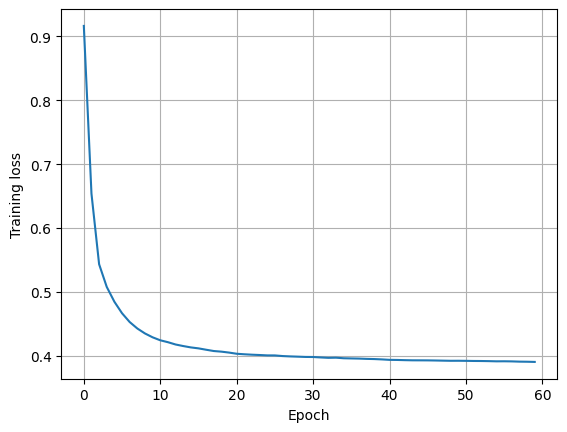

Test accuracy: 0.851371237458194
Confusion matrix:
 [[18042  2349  4371]
 [ 5594 23557  2206]
 [ 3129  2349 72953]]


In [26]:

# ============================================================
# Loss plot
# ============================================================
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.grid()
plt.show()

# ============================================================
# Evaluation
# ============================================================
model.eval()
with torch.no_grad():
    logits = model(X_test_t)
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1).cpu().numpy()

# Accuracy
print("Test accuracy:", accuracy_score(y_test, preds))

# Confusion matrix
print("Confusion matrix:\n", confusion_matrix(y_test, preds))


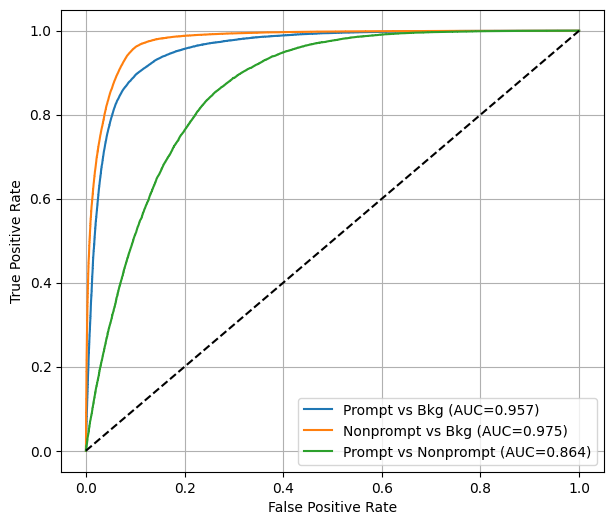

In [27]:

# ============================================================
# ROC curves
# ============================================================
probs_np = probs.cpu().numpy()

def make_roc(mask, positive_label, prob_idx):
    y_true = (y_test[mask] == positive_label).astype(int)
    scores = probs_np[mask, prob_idx]
    fpr, tpr, _ = roc_curve(y_true, scores)
    return fpr, tpr, auc(fpr, tpr)

plt.figure(figsize=(7,6))

for label, mask, pos, idx in [
    ("Prompt vs Bkg",      (y_test!=1), 0, 0),
    ("Nonprompt vs Bkg",   (y_test!=0), 1, 1),
    ("Prompt vs Nonprompt",(y_test!=2), 0, 0),
]:
    fpr, tpr, a = make_roc(mask, pos, idx)
    plt.plot(fpr, tpr, label=f"{label} (AUC={a:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()
